# Boiler Aufheizkurve

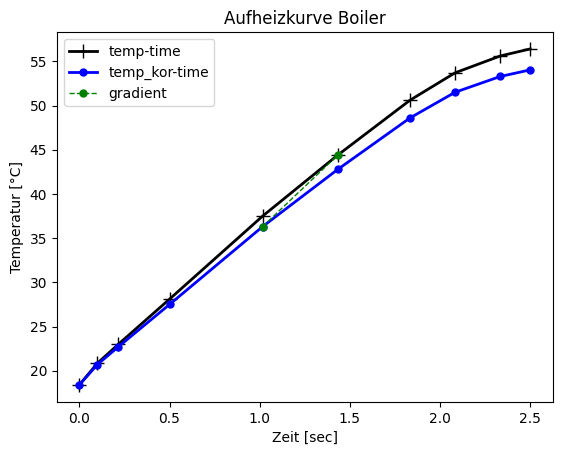

In [16]:
from matplotlib import pyplot as plt
import numpy as np

time_meas_s   = np.array([0,6,13,30,61,86,110,125,140,150])*60.
temp_meas_deg = np.array([18.4,20.85,23.0,28.1,37.5,44.4,50.6,53.7,55.6,56.4])

P = 2000

dtemp_vec = np.empty(shape=(time_meas_s.size, 1), dtype=float)
dtemp_kor_vec = np.empty(shape=(time_meas_s.size, 1), dtype=float)
temp_kor_vec= np.empty(shape=(time_meas_s.size, 1), dtype=float)

temp_kor_vec[0] = 18.4

for i in range(1,time_meas_s.size):
  delta_temp = temp_meas_deg[i]-temp_meas_deg[i-1]
  delta_time = time_meas_s[i]-time_meas_s[i-1]
  dtemp_vec[i] = delta_temp/delta_time


  # Mischtemperatur mit 5 l mit 18.4 °C
  temp_kor_vec[i] = (75.*temp_meas_deg[i]+5*18.5)/80

  delta_kor_temp   = temp_meas_deg[i]-temp_kor_vec[i-1]
  dtemp_kor_vec[i] = delta_kor_temp/delta_time

  # print(f"dtemp_vec[{i}] {dtemp_vec[i]}, dtemp_kor_vec[{i}] {dtemp_kor_vec[i]}, quot = {dtemp_kor_vec[i]/dtemp_vec[i]}")

dtemp_vec[0] = dtemp_vec[1]  
dtemp_kor_vec[0] = dtemp_kor_vec[1] 

# a = np.empty(shape=(25, 2), dtype=int)
# for x in range(1, 6):
#     for y in range(1, 6):
#         index = (x-1)*5+(y-1)
#         a[index] = x, y

time_grad_vec = np.empty(shape=(2, 1), dtype=float)
temp_grad_vec = np.empty(shape=(2, 1), dtype=float)

time_grad_vec[0] = time_meas_s[4]
time_grad_vec[1] = time_meas_s[5]
temp_grad_vec[0] = temp_kor_vec[4]
temp_grad_vec[1] = temp_meas_deg[5]

plt.plot(time_meas_s/60./60.,temp_meas_deg,color='#000000',linestyle='-',linewidth=2,marker='+',markersize=10,label='temp-time')
plt.plot(time_meas_s/60./60.,temp_kor_vec,color='b',linestyle='-',linewidth=2,marker='o',markersize=5,label='temp_kor-time')
plt.plot(time_grad_vec/60./60.,temp_grad_vec,color='g',linestyle='--',linewidth=1,marker='o',markersize=5,label='gradient')

plt.title('Aufheizkurve Boiler')
plt.xlabel('Zeit [sec]')
plt.ylabel('Temperatur [°C]')
plt.legend()
plt.show()

In [17]:
# dy/dt(t) + a * y(t) = b * u(t)
#
# +-          -+   +-               -+   +- -+
# | dy/dt(i)   |   | -y(i)    u(i)   | * | a |
# | dy/dt(i+1) | = | -y(i+1)  u(i+1) | * | b |
# | dy/dt(i+2) |   | -y(i+2)  u(i+2) |   +- -+
# +-          -+   +-               -+

y = np.empty(shape=(time_meas_s.size, 1), dtype=float)
A = np.empty(shape=(time_meas_s.size, 2), dtype=float)
x = np.empty(shape=(2, 1), dtype=float)

for i in range(0,time_meas_s.size):
  y[i] = dtemp_kor_vec[i]
  A[i] = -(temp_meas_deg[i]-temp_meas_deg[0]), P


B = A.conj().transpose()
AA = B @ A
yy = B @ y
x = np.linalg.lstsq(AA, yy, rcond=None)

x = np.linalg.inv(AA) @ yy

a = x[0][0]
b = x[1][0]*0.965

print("dT/dt(t) + a * T(t) = b * P(t)")
print("------------------------------")
print(f"a = {a}")
print(f"b = {b}")
print("------------------------------")



dT/dt(t) + a * T(t) = b * P(t)
------------------------------
a = 3.2124634217420266e-05
b = 3.018108520160439e-06
------------------------------


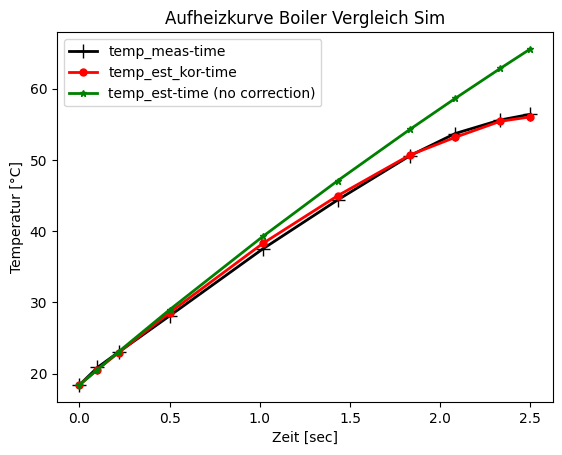

In [18]:
temp_est     = np.empty(shape=(time_meas_s.size, 1), dtype=float)
temp_est_kor = np.empty(shape=(time_meas_s.size, 1), dtype=float)
temp_est_kor[0] = 0.
temp_est[0] = 0.
temp_est_kor_stern = 0.

for i in range(1,time_meas_s.size):

  e = np.exp(-a*(time_meas_s[i]-time_meas_s[i-1]))
  temp_est_kor[i] = e * temp_est_kor_stern +  P * b /a *(1. - e ) 

  # Mischtemperatur mit 5 l mit 18.4 °C
  temp_est_kor_stern = (75.*(temp_est_kor[i]+temp_meas_deg[0])+5*temp_meas_deg[0])/80
  temp_est_kor_stern -= temp_meas_deg[0]

  temp_est[i] = e * temp_est[i-1] +  P * b /a *(1. - e ) 


temp_est_kor += temp_meas_deg[0]
temp_est     += temp_meas_deg[0]

plt.plot(time_meas_s/60./60.,temp_meas_deg,color='#000000',linestyle='-',linewidth=2,marker='+',markersize=10,label='temp_meas-time')
plt.plot(time_meas_s/60./60.,temp_est_kor,color='r',linestyle='-',linewidth=2,marker='o',markersize=5,label='temp_est_kor-time')
plt.plot(time_meas_s/60./60.,temp_est,color='g',linestyle='-',linewidth=2,marker='*',markersize=5,label='temp_est-time (no correction)')

plt.title('Aufheizkurve Boiler Vergleich Sim')
plt.xlabel('Zeit [sec]')
plt.ylabel('Temperatur [°C]')
plt.legend()
plt.show()

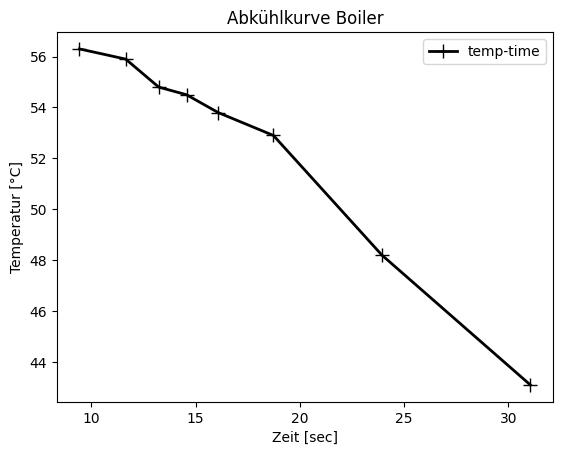

In [19]:
time_abkuehl_s   = np.array([9+26/60 , 11+39/60, 13+14/60, 14+34/60, 16+5/60, 18+44/60, 23+56/60, 31+3/60])*3600.
temp_abkuehl_deg = np.array([56.3, 55.9, 54.8, 54.5, 53.8, 52.9, 48.2, 43.1])
V_abkuehl_l     = np.array([5,5,6,5,5,5,5,5])

plt.plot(time_abkuehl_s/60./60.,temp_abkuehl_deg,color='#000000',linestyle='-',linewidth=2,marker='+',markersize=10,label='temp-time')

plt.title('Abkühlkurve Boiler')
plt.xlabel('Zeit [sec]')
plt.ylabel('Temperatur [°C]')
plt.legend()
plt.show()